# Tweet Sentiment Analysis Practice

[Data Source](https://data.world/crowdflower/brands-and-product-emotions)

## Business Understanding

Our goal is to build a proof-of-concept classifier which would allow Apple to monitor sentiment toward its products (and the products of its top competitors) on Twitter.

In particular, Apple needs to be able to monitor *negative sentiment* towards its products and that of its competitors to respond quickly to customer dissatisfaction to resolve the issue (or, in the case of its competitors, to proactively avoid their pain points.)

## Data Understanding

We have a collection of ~9,000 tweets concerning Apple, Android and Google products with the sentiment labeled ("positive", "negative", "neutral", or "I can't tell") and the object of the sentiment in the tweet.

## Imports

In [55]:
# set a random seed for reproducibility
seed = 3490

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.container import BarContainer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import string
from nltk.corpus import stopwords

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from nltk.corpus import wordnet
import nltk

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import gensim.downloader

from sklearn.decomposition import PCA

from gensim.models import Word2Vec

## Load Data

In [56]:
# load data from file; encoding is "latin1"
data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='latin1')

# inspect first few rows
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [57]:
data.shape

(9093, 3)

How many tweets contains #SXSW or #sxsw? (Answer: most of them.)

In [58]:
data_list = data.dropna().copy()
data_list['tweet_words'] = data_list.tweet_text.map(lambda x: x.split())
exploded = data_list.reset_index().rename({'index': 'true_index'}, axis=1).explode('tweet_words')
about_sxsw = exploded.loc[(exploded.tweet_words == '#SXSW') | (exploded.tweet_words == '#sxsw')].true_index.values

In [59]:
for tweet in data.tweet_text.loc[about_sxsw].sample(5):
    print(tweet)

@mention #SXSW don't forget @mention to plan your schedule. Plus our free iphone app {link}
Outside of 9:30 panels which 75% of people skip I can barely get anything to work on my iPhone. #sxsw needs to shrink by 10k people.
I want one!! It's not a rumor: Apple is opening up a temporary store in downtown Austin for #SXSW and the iPad 2 launch {link}
If you haven't waited in line for an Apple product you're missing out on an important rite of passage.  #sxsw
Apple set to open popup shop in core of #SXSW action {link} Geeks need #iPad2 love!


## Explore Data

The column names are a mouthful ("is_there_an_emotion_directed_at_a_brand_or_product"), so let's rename them for ease.

In [60]:
# rename last two columns, in place
data.rename({'emotion_in_tweet_is_directed_at': 'object_of_sentiment',
             'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, axis=1, inplace=True)
# inspect first few rows
data.head()

,tweet_text,object_of_sentiment,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Now let's explore the distribution of the data.

In [61]:
data.sentiment.value_counts()

sentiment
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

Sample a few tweets which have unlabeled sentiment.

In [62]:
for i in data.loc[data.sentiment=="I can't tell"].sample(5, random_state=seed).index:
    print(data.loc[i, 'tweet_text'])

Finally got my #SXSW schedule on my #google calendar. #coudbeeasier
funny! iphone correction? RT @mention Dashing off to learn a thing or two about longhorn journalism #SXSW
&quot;Do you know what Apple is really good at? Making you feel bad about your Xmas present!&quot; - Seth Meyers on iPad2 #sxsw #doyoureallyneedthat?
+1 ÛÏ@mention +1 RT @mention Petricone says Google TV is just a browser. I don't think that's correct. #SXSWÛ
RT @mention Gary Vaynerchuck lÌ_gger ner winelibrary.tv och slÌ_pper i stÌ_llet Iphone-appen Daily Grape. #thankyoueconomy #sxsw #swesxsw


Only one of these is clearly negative. However, forcing the classifier to treat them as positive, negative or neutral would probably yield some valuable insights for the brand (example: why don't you use your iPad on the go? Can the iPhone alarm clock be improved?) \*Sorry, I didn't set the random_state initially! These comments were in reference to a different sample of tweets.

With that being said, the records with unlabeled sentiment represent only a small portion of the dataset, and introducing semi-supervised labels here may have an unexpected effect given that the original labellers already classified these tweets as ambiguous. I will drop these records.

In [63]:
# replace "I can't tell" in sentiment column with null
data.sentiment = data.sentiment.replace({"I can't tell": None})

In [64]:
# drop records with null value for sentiment
data.dropna(subset='sentiment', inplace=True)

Now let's explore the distribution of products discussed in these tweets.

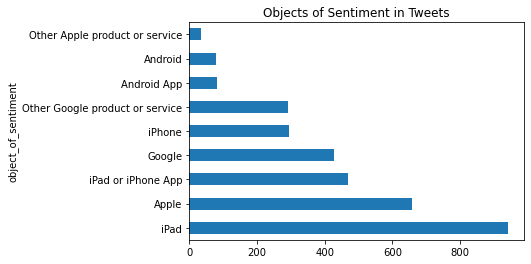

In [65]:
fig, ax = plt.subplots()

ax.set_title('Objects of Sentiment in Tweets')

data.object_of_sentiment.value_counts().plot(kind='barh');

We have the most data on Apple products, and a little sprinkling of data on Google and Android products.

What is the sentiment breakdown by object?

Before we answer this question, first note that more than half of records do not have an object of sentiment.

In [66]:
data.object_of_sentiment.isna().sum()

5655

Check how many of these null sentiment records correspond to tweets which are neutral or unlabeled.

In [67]:
data.loc[(data.sentiment=='No emotion toward brand or product') | (data.sentiment=="I can't tell"),
         'object_of_sentiment'].isna().sum()

5298

There are 5298 records for which sentiment is unknown or neutral, and the "object_of_sentiment" value is null. But this means that there are a few records for which no object is given, despite a positive or negative sentiment being recorded.

Let's view an example of such a tweet.

In [68]:
for i in data.loc[((data.sentiment=='Positive emotion') | (data.sentiment=='Negative emotion')) &
                  (data.object_of_sentiment.isna())].sample(3, random_state=seed).index:
    print(data.loc[i, 'tweet_text'])

My iPhone says it can't connect to the Internet even though #sxsw wifi works great on my computer. Any suggestions?
RT @mention The Web DesignerÛªs Guide to iOS (and Android) Apps, today @mention 10 a.m! {link} #sxsw
Imagine if every company had the 20% concept like Google. #bavcID #SXSW


One approach to deal with these null objects is to classify them using the labeled data as training data (semi-supervised learning.)

We may mis-classify some tweets -- for example, tweet 64 is not directed at a specific Apple product at all -- but hopefully we can capture the fact that some of these *are* clearly directed at specific products.

Before we complete the above semi-supervised learning task for the "object_of_sentiment" category, let's look at the current distribution of positive, negative and neutral tweets by product.

In [69]:
data.loc[data.object_of_sentiment=='iPad', 'sentiment'].value_counts().to_frame().reset_index()

,sentiment,count
0,Positive emotion,793
1,Negative emotion,125
2,No emotion toward brand or product,24


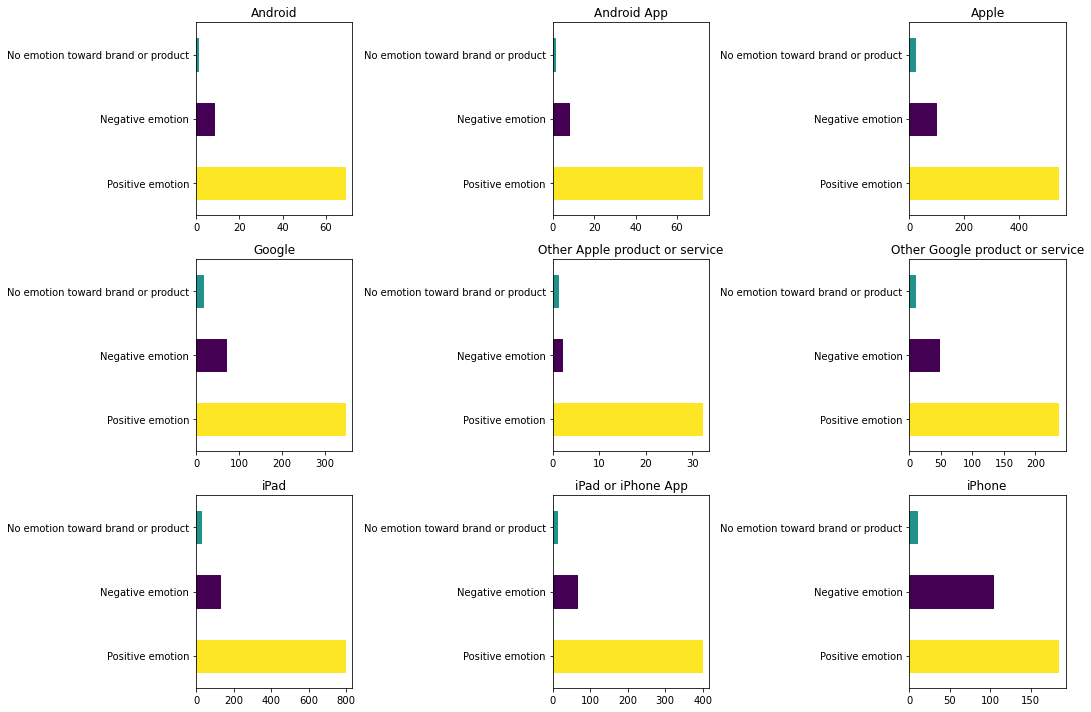

In [70]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

# set up color map for negative, positive and neutral tweets
viridis = mpl.colormaps['viridis'].resampled(3)

for n, product in enumerate(np.unique(data.object_of_sentiment.to_list())[:-1]):
    # get sentiment counts for this product
    df = data.loc[data.object_of_sentiment==product, 'sentiment'].value_counts().to_frame().reset_index()

    # plot bar chart
    df.plot(kind='barh', ax=ax[n//3][n%3])
    
    # set colors for each bar according to whether it is the count of positive, negative or neutral tweets
    bars = [i for i in ax[n//3][n%3].containers if isinstance(i, BarContainer)]
    colors = df.sentiment.replace({'Positive emotion': 2,
                                   'Negative emotion': 0,
                                   'No emotion toward brand or product': 1})
    for i in range(3):
        bars[0][i].set_color(viridis(colors[i]/2))
    
    # fix labels, remove legend
    ax[n//3][n%3].set_yticklabels(df['sentiment'])
    ax[n//3][n%3].get_legend().remove()
    
    # set title
    ax[n//3][n%3].set_title(f'{product}')
    
fig.tight_layout();

The iPhone has the highest ratio of negative to positive emotion tweets.

Let's dig in a little more to customer sentiment toward Apple products.

In [71]:
data.head(1)

,tweet_text,object_of_sentiment,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion


In [72]:
apple_products = ['iPhone', 'iPad or iPhone App', 'iPad', 'Other Apple product or service', 'Apple']
sentiments = np.unique(data.sentiment)

for product in apple_products:
    for sentiment in sentiments:
        try:
            print(f'{sentiment} toward {product}:')
            text = data.loc[
                (data.object_of_sentiment==product)&(data.sentiment==sentiment), 'tweet_text'].sample(1).values[0]
            print(text)
            print('\n')
        except:
            continue

Negative emotion toward iPhone:
With just my iPhone and iPad on me, I feel very unequipped compared to everyone else. Dang! #sxsw


No emotion toward brand or product toward iPhone:
Still using the original first-generation iPhone. Wondering if this will get me kicked out of #SXSW


Positive emotion toward iPhone:
@mention Feature @mention for the iPhone. We will be all over #SXSW this week!


Negative emotion toward iPad or iPhone App:
NYT app for iPad: not &quot;here's an amazing way to serve our readership,&quot; more &quot;here's a market opportunity we can't ignore.&quot; #sxsw #newsapps


No emotion toward brand or product toward iPad or iPhone App:
Just got @mention new iPhone app, The Dialy Grape: {link} #sxsw #thankyou


Positive emotion toward iPad or iPhone App:
Unexpected geekout moment of #sxsw so far: talked with the guys who are bringing the Traveller RPG to the iPhone.


Negative emotion toward iPad:
In iPad Design Headaches: Take Two Tablets, Call Me in the AM panel - 

How many tweets are concerning Apple?

In [73]:
data.loc[data.object_of_sentiment.isin(apple_products)].shape

(2402, 3)

In [74]:
2402 / len(data)

0.268770280854873

Roughly 27% of our data concerns Apple products.

## Semi-supervised Learning

Apply semi-supervised learning to classify the object_of_sentiment for tweets with positive or negative sentiment.

In [75]:
# get all tweets with positive or negative sentiment
emotive_tweets = data.loc[(data.sentiment=='Positive emotion') | (data.sentiment=='Negative emotion')]
emotive_tweets.head()

,tweet_text,object_of_sentiment,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [76]:
# separate into "train" and "predict"
train = emotive_tweets.loc[emotive_tweets.object_of_sentiment.isna()==False]
predict = emotive_tweets.loc[emotive_tweets.object_of_sentiment.isna()]

In [77]:
# check shapes
train.shape[0] + predict.shape[0] == emotive_tweets.shape[0]

True

Now, we want to build a classifier to classify the object_of_sentiment for the "predict" set based on the labels in the "train" set.

In [78]:
train_target = train['object_of_sentiment']
train_features = train['tweet_text']

We need to label encode the target, then vectorize the tweet text.

We now run into the problem that we are going to have when building the sentiment classifier; there are many different ways that we could preprocess the tweet text prior to modeling, and when you combine this with all of the classification algorithms we could use and their hyperparameters to be tuned, we have a truly large search space for the "best" model to do the job.

For this reason, I plan to drop this data for now and return to this piece of the project after building out a classifier below. I will use whatever preprocessing techniques resulted in the best performance for identifying the object of the sentiment, and I will apply that preprocessing technique to the "training data" for labeling the unlabeled object_of_sentiment values, then build a classifier to label these missing values.

When I add the newly labeled data to the rest of the training data and refit the best-performing classifier as determined below, if the performance improves or stays the same, I will keep it. Otherwise, this data will be permanently dropped.

## Modeling

Our goal is to build a classifier which identifies the i.) sentiment and ii.) object of sentiment of a tweet.

We are going to build the classifier in steps:

1.) Classify a tweet as negative or not negative (positive or neutral, with no distinction between the two.)

2.) Classify the object of the sentiment in a tweet.

3.) Combine 1 and 2.

4.) Classify a tweet as positive, negative or neutral and identify the object of the sentiment (if applicable.)

It is not critically important that our classifier be able to distinguish between positive and neutral tweets (hence, it is the last step in our process.)

In [79]:
data.isna().sum()

tweet_text                1
object_of_sentiment    5655
sentiment                 0
dtype: int64

In [80]:
# drop tweet that is missing tweet_text
data.dropna(subset='tweet_text', inplace=True)
print(f'We now have {data.shape[0]} records.')

We now have 8936 records.


### Train Test Split

In [81]:
# separate features and target
X = data['tweet_text']
y = data['sentiment']

# label encode the target
le = LabelEncoder()
y_encoded = pd.Series(le.fit_transform(y), index=y.index)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=seed)

# train val split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

# check shapes
print(X_train.shape)
print(y_train.shape)
print('\n')
print(X_val.shape)
print(y_val.shape)
print('\n')
print(X_test.shape)
print(y_test.shape)

(5718,)
(5718,)


(1430,)
(1430,)


(1788,)
(1788,)


In [82]:
y_train.value_counts(normalize=True)

1    0.602134
2    0.335607
0    0.062260
Name: proportion, dtype: float64

In [83]:
dict(zip([0, 1, 2], le.classes_))

{0: 'Negative emotion',
 1: 'No emotion toward brand or product',
 2: 'Positive emotion'}

We may have some difficulty capturing the negative class due to its tiny minority! We may even have some difficulty capturing the positive class, also; the neutral class is so big.

### Preprocessing

I am going to try three different methods of preprocessing the tweet text to pass in to the model. The tweets need to be "clean" (lower cased, with punctuation removed and, ideally, some form of tokenization applied) before these methods can be applied, so we are going to do that preprocessing work first. We will also remove some common English stop words.

The vectorization / embedding techniques to then be applied are:
- count or term frequency inverse document frequency vectorization (using Scikit Learn's implementations; we will try both)
- using pretrained GloVe embeddings and a mean word embedding for each tweet
- training a Word2Vec model on our corpus to obtain embeddings (using gensim) and using a mean word embedding for each tweet

A fourth and final possible technique to be applied is stacking a combination of these embeddings/vectorizations to pass into the model, along with any other potentially helpful features (e.g. TextBlob's sentiment analysis polarity results for the tweet.)

#### General Clean Up

We can apply general clean up techniques and tokenization to the entire training data without leakage, so we will do that first:

In [84]:
# clean up (remove punctuation & change to lower case) tweets & remove english stopwords
import string
from nltk.corpus import stopwords

stopwords_list = stopwords.words('english')

def clean_up(tweet):
    return ' '.join([word.strip(string.punctuation).lower() for word in tweet.split() if
                     word not in stopwords_list])

In [85]:
X_train.apply(clean_up).head()

5390    rt mention android developers friends let's ha...
5237    rt mention ipad design tip looks like physical...
7148                            apple store atx link sxsw
7206    my life would much better ipad brainwashed lin...
5416    rt mention apple autocorrect weird ogilvy auto...
Name: tweet_text, dtype: object

#### Tokenization

We can employ stemming or lemmatization to obtain tokens for vectorization.

Stemming is very simple with nltk's Porter Stemmer:

In [86]:
# stemming
from nltk.stem import PorterStemmer

def get_stems(tweet):
    '''Takes in a string of words and outputs a string of stemmed tokens.'''
    stemmer = PorterStemmer()
    return ' '.join([stemmer.stem(word) for word in tweet.split()])

# test
get_stems("hi i'm rob and i'm going swimming tomorrow woohoo")

"hi i'm rob and i'm go swim tomorrow woohoo"

Lemmatization looks more complicated, but this is only because the lemmatizer from WordNet works best if part-of-speech tags are passed to it along with the word itself. Most of the code below generates a wordnet version of a part of speech tag for a word and passes it in to the lemmatizer along with the word itself.

In [87]:
# lemmatization

# imports
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk

# helper function to get wordnet pos_tags from nltk pos_tags
def get_wordnet_pos(tag):
    '''Convert POS tags generated by nltk.pos_tag to wordnet tags, for use with word net
    lemmatizer provided in the nltk.stem.wordnet package.'''
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# define function to apply lemmatizer to wordnet-tagged words to get lemmas
def get_lemmas(tweet):
    '''Takes in a string (tweet) and returns string of lemmatized tokens.'''
    # instantiate word net lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    nltk_pos_tags = nltk.pos_tag(tweet.split()) # list of (word, pos_tag)
    
    wordnet_pos_tags = [(pair[0], get_wordnet_pos(pair[1])) for pair in nltk_pos_tags]
    
    return ' '.join([lemmatizer.lemmatize(*tagged_word) for tagged_word in wordnet_pos_tags])

# test
get_lemmas("hi i'm rob and i'm going swimming tomorrow woohoo")

"hi i'm rob and i'm go swim tomorrow woohoo"

In [88]:
# get stemmed and lemmatized tokens for training & validation data
X_train_stems = X_train.apply(clean_up).apply(get_stems)
X_train_lemmas = X_train.apply(clean_up).apply(get_lemmas)

X_val_stems = X_val.apply(clean_up).apply(get_stems)
X_val_lemmas = X_val.apply(clean_up).apply(get_lemmas)

In [89]:
X_train_stems.head(2)

5390    rt mention android develop friend let' hang 12...
5237    rt mention ipad design tip look like physic ob...
Name: tweet_text, dtype: object

In [90]:
X_train_lemmas.head(2)

5390    rt mention android developer friends let's han...
5237    rt mention ipad design tip look like physical ...
Name: tweet_text, dtype: object

We see an example of stemming versus lemmatization in tweet 5237: stemming results in "physic", lemmatization results in "physical".

The classifiers we will test out with are preprocessed data are random forest, naive bayes and support vector machine. We are not testing logistic regression because it is not particularly suited to a multi-class classification problem, and we are not using KNN because it is possible that two tweets which are both positive will contain very different content.

I will store my results in the `model_eval` dictionary below which can easily be displayed as a DataFrame to view the model tuning process over time.

In [91]:
model_eval = {'tokenization': [], 'preprocessing': [], 'classifier': [], 'score': []}

def score_model(model, X_train, y_train, X_val, y_val, token, preprocess, clf):
    global model_eval
    try:
        model.fit(X_train, y_train)
    except:
        print('Error fitting model; check training data. Is it scaled? Try fitting separately to troubleshoot.')
        return 0
    
    model_eval['tokenization'].append(token)
    model_eval['preprocessing'].append(preprocess)
    model_eval['classifier'].append(clf)
    model_eval['score'].append(model.score(X_val, y_val))
    
    return pd.DataFrame(model_eval).tail()

In [92]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer()

final_X_train = pd.DataFrame(count.fit_transform(X_train_stems).todense(), index=X_train_stems.index,
                                                    columns=count.vocabulary_)
final_X_val = pd.DataFrame(count.transform(X_val_stems).todense(), index=X_val.index, columns=count.vocabulary_)

final_X_train.head(2)

,rt,mention,android,develop,friend,let,hang,12,30p,saturday,...,webmail,suppose,forb,mahalo,97,woop,youkidshavefun,tdg,exclud,interface
5390,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5237,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


For random forest and naive bayes, it is not strictly necessary to scale the data. Let's go ahead and get scores for these two models.

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

rf = RandomForestClassifier(random_state=seed)
nb = MultinomialNB()

score_model(rf, final_X_train, y_train, final_X_val, y_val, 'stem', 'count_vectorize', 'random_forest')
score_model(nb, final_X_train, y_train, final_X_val, y_val, 'stem', 'count_vectorize', 'naive_bayes')

,tokenization,preprocessing,classifier,score
0,stem,count_vectorize,random_forest,0.676923
1,stem,count_vectorize,naive_bayes,0.684615


For a support vector machine classifier, we do need to scale the data.

In [94]:
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC

ss = StandardScaler()

scaled_X_train = ss.fit_transform(final_X_train)
scaled_X_val = ss.transform(final_X_val)

svc = SVC(random_state=seed)

score_model(svc, scaled_X_train, y_train, scaled_X_val, y_val, 'stem', 'count_vectorize', 'support_vector')

,tokenization,preprocessing,classifier,score
0,stem,count_vectorize,random_forest,0.676923
1,stem,count_vectorize,naive_bayes,0.684615
2,stem,count_vectorize,support_vector,0.653147


With stemming and count vectorization, Naive Bayes is in the lead.

Now we need to tune these classifiers, then tune the preprocessing technique (count vectorization) itself.

Before we do so, let's check the model scores with the same preprocessing technique, but lemmatization instead of stemming.

In [95]:
# refit count vectorizer and standard scaler with lemmatized data

final_X_train = pd.DataFrame(count.fit_transform(X_train_lemmas).todense(), index=X_train_lemmas.index,
                                                    columns=count.vocabulary_)
final_X_val = pd.DataFrame(count.transform(X_val_lemmas).todense(), index=X_val_lemmas.index,
                           columns=count.vocabulary_)

scaled_X_train = ss.fit_transform(final_X_train)
scaled_X_val = ss.transform(final_X_val)

# score models with new training and validation data

score_model(rf, final_X_train, y_train, final_X_val, y_val, 'lemmatize', 'count_vectorize', 'random_forest')
score_model(nb, final_X_train, y_train, final_X_val, y_val, 'lemmatize', 'count_vectorize', 'naive_bayes')
score_model(svc, scaled_X_train, y_train, scaled_X_val, y_val, 'lemmatize', 'count_vectorize', 'support_vector')

,tokenization,preprocessing,classifier,score
1,stem,count_vectorize,naive_bayes,0.684615
2,stem,count_vectorize,support_vector,0.653147
3,lemmatize,count_vectorize,random_forest,0.679021
4,lemmatize,count_vectorize,naive_bayes,0.683916
5,lemmatize,count_vectorize,support_vector,0.647552


The best performing classifier so far is Naive Bayes, and it performs 0.1% better with stemming, rather than lemmatization, so we'll use the stemmed and count-vectorized data to tune our Naive Bayes classifier next. Then we can turn our attention back to tuning the count vectorizer itself.

In [96]:
best_X_train = pd.DataFrame(count.fit_transform(X_train_stems).todense(), index=X_train_stems.index,
                            columns=count.vocabulary_)
best_X_val = pd.DataFrame(count.transform(X_val_stems).todense(), index=X_val_stems.index,
                          columns=count.vocabulary_)
best_X_train.head(2)

,rt,mention,android,develop,friend,let,hang,12,30p,saturday,...,webmail,suppose,forb,mahalo,97,woop,youkidshavefun,tdg,exclud,interface
5390,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5237,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [1, 0.5, 10]}

grid_search = GridSearchCV(nb, param_grid, scoring='accuracy')

grid_search.fit(best_X_train, y_train)

GridSearchCV(estimator=MultinomialNB(), param_grid={'alpha': [1, 0.5, 10]},
             scoring='accuracy')

In [98]:
grid_search.best_score_

0.6631672570648949

There is very little that can be done to tune a Naive Bayes classifier. Changing the smoothing parameter didn't have a great effect.

So we'll move on to tuning the count vectorizer.

In [99]:
len(count.vocabulary_)

6512

Currently, the "baseline" count vectorizer has a vocabulary of 6512 lemmas.

One technique we can try to improve the classifier's performance is limiting the vectorizer's vocabulary to only those words which show up often enough *and* little enough to qualify as being meaningful. (Example: 'the' shows up too often to provide information, but a word which only shows up once in the entire corpus also won't help us, for example, a specific person's username.)

The below vectorizer has a "maximum document frequency" of 90% (only include a token if it appears in fewer than 90% of tweets) and a "minimum document frequency" of 5% (only include tokens which appear in more than 5% of all tweets.)

In [100]:
count = CountVectorizer(min_df=0.05, max_df=0.9)

final_X_train = pd.DataFrame(count.fit_transform(X_train_stems).todense(), index=X_train_stems.index,
                                                    columns=count.vocabulary_)
final_X_val = pd.DataFrame(count.transform(X_val_stems).todense(), index=X_val_stems.index,
                           columns=count.vocabulary_)

score_model(nb, final_X_train, y_train, final_X_val, y_val, 'stem', count, nb)

,tokenization,preprocessing,classifier,score
2,stem,count_vectorize,support_vector,0.653147
3,lemmatize,count_vectorize,random_forest,0.679021
4,lemmatize,count_vectorize,naive_bayes,0.683916
5,lemmatize,count_vectorize,support_vector,0.647552
6,stem,"CountVectorizer(max_df=0.9, min_df=0.05)",MultinomialNB(),0.612587


Our model's score is worse (by about 7%.) Let's try a more conservative maximum document frequency.

In [101]:
count = CountVectorizer(min_df=0.05, max_df=0.95)

final_X_train = pd.DataFrame(count.fit_transform(X_train_stems).todense(), index=X_train_stems.index,
                                                    columns=count.vocabulary_)
final_X_val = pd.DataFrame(count.transform(X_val_stems).todense(), index=X_val_stems.index,
                           columns=count.vocabulary_)

score_model(nb, final_X_train, y_train, final_X_val, y_val, 'stem', count, nb)

,tokenization,preprocessing,classifier,score
3,lemmatize,count_vectorize,random_forest,0.679021
4,lemmatize,count_vectorize,naive_bayes,0.683916
5,lemmatize,count_vectorize,support_vector,0.647552
6,stem,"CountVectorizer(max_df=0.9, min_df=0.05)",MultinomialNB(),0.612587
7,stem,"CountVectorizer(max_df=0.95, min_df=0.05)",MultinomialNB(),0.612587


Taking out information doesn't seem to be improving the model's performance, so let's try adding information by including bigrams in our training data.

In [102]:
count = CountVectorizer(ngram_range=(1, 2))

final_X_train = pd.DataFrame(count.fit_transform(X_train_stems).todense(), index=X_train_stems.index,
                                                    columns=count.vocabulary_)
final_X_val = pd.DataFrame(count.transform(X_val_stems).todense(), index=X_val_stems.index,
                           columns=count.vocabulary_)

score_model(nb, final_X_train, y_train, final_X_val, y_val, 'stem', count, nb)

,tokenization,preprocessing,classifier,score
4,lemmatize,count_vectorize,naive_bayes,0.683916
5,lemmatize,count_vectorize,support_vector,0.647552
6,stem,"CountVectorizer(max_df=0.9, min_df=0.05)",MultinomialNB(),0.612587
7,stem,"CountVectorizer(max_df=0.95, min_df=0.05)",MultinomialNB(),0.612587
8,stem,"CountVectorizer(ngram_range=(1, 2))",MultinomialNB(),0.690909


Adding bigrams very slightly improved the model's performance.

It's probably worth giving our other two classifiers a chance to be tuned as well before dismissing them out of hand (especially since there was so little to tune in the best model - there are a lot more knobs to turn for random forest, so perhaps it will improve significantly over the baseline.)

Going back to simply X_train_stems, let's tune our random forest classifier next.

Increasing the number of estimators should improve performance. Limiting the maximum depth of individual decision trees can help those trees not to overfit. It's possible that weighting the classes according to their ratios could improve performance as well.

In [103]:
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [2, 10, 20, 50],
              'random_state': [seed]}

rf = RandomForestClassifier()

grid_search = GridSearchCV(rf, param_grid, scoring='accuracy')

grid_search.fit(final_X_train, y_train)

grid_search.best_score_

0.6411328610147508

Tuning the random forest failed miserably. Let's try different versions of count vectorize paired with the random forest.

In [104]:
count = CountVectorizer(min_df=0.05, max_df=0.95)

final_X_train = pd.DataFrame(count.fit_transform(X_train_stems).todense(), index=X_train_stems.index,
                             columns=count.vocabulary_)
final_X_val = pd.DataFrame(count.transform(X_val_stems).todense(), index=X_val_stems.index,
                           columns=count.vocabulary_)

score_model(rf, final_X_train, y_train, final_X_val, y_val, 'stem', count, rf)

,tokenization,preprocessing,classifier,score
5,lemmatize,count_vectorize,support_vector,0.647552
6,stem,"CountVectorizer(max_df=0.9, min_df=0.05)",MultinomialNB(),0.612587
7,stem,"CountVectorizer(max_df=0.95, min_df=0.05)",MultinomialNB(),0.612587
8,stem,"CountVectorizer(ngram_range=(1, 2))",MultinomialNB(),0.690909
9,stem,"CountVectorizer(max_df=0.95, min_df=0.05)","(DecisionTreeClassifier(max_features='sqrt', r...",0.575524


Once again, let's try adding bigrams instead of specifying document frequency limits.

In [105]:
count = CountVectorizer(ngram_range=(1, 2))

final_X_train = pd.DataFrame(count.fit_transform(X_train_stems).todense(), index=X_train_stems.index,
                             columns=count.vocabulary_)
final_X_val = pd.DataFrame(count.transform(X_val_stems).todense(), index=X_val_stems.index,
                           columns=count.vocabulary_)

score_model(rf, final_X_train, y_train, final_X_val, y_val, 'stem', count, rf)

,tokenization,preprocessing,classifier,score
6,stem,"CountVectorizer(max_df=0.9, min_df=0.05)",MultinomialNB(),0.612587
7,stem,"CountVectorizer(max_df=0.95, min_df=0.05)",MultinomialNB(),0.612587
8,stem,"CountVectorizer(ngram_range=(1, 2))",MultinomialNB(),0.690909
9,stem,"CountVectorizer(max_df=0.95, min_df=0.05)","(DecisionTreeClassifier(max_features='sqrt', r...",0.575524
10,stem,"CountVectorizer(ngram_range=(1, 2))","(DecisionTreeClassifier(max_features='sqrt', r...",0.657343


Let's tune our support vector machine, then move on to other preprocessing techniques.

In [106]:
# too long

# count = CountVectorizer()

# final_X_train = pd.DataFrame(count.fit_transform(X_train_stems).todense(), index=X_train_stems.index,
#                              columns=count.vocabulary_)
# final_X_val = pd.DataFrame(count.transform(X_val_stems).todense(), index=X_val_stems.index,
#                            columns=count.vocabulary_)

# scaled_X_train = pd.DataFrame(ss.fit_transform(final_X_train), index=final_X_train.index,
#                               columns=final_X_train.columns)
# scaled_X_val = pd.DataFrame(ss.transform(final_X_val), index=final_X_val.index,
#                             columns=final_X_val.columns)

# param_grid = [
#     {'C': [0.01, 0.1, 1],
#      'kernel': ['poly', 'rbf'],
#      'gamma': [0.001, 0.005, 0.01],
#      'class_weight': ['balanced', {0:1, 1:1, 2:1}]}
# ]

# grid_search = GridSearchCV(svc, param_grid, scoring='accuracy')

# grid_search.fit(scaled_X_train, y_train)

# grid_search.best_score_

In [107]:
# count = CountVectorizer()

final_X_train = pd.DataFrame(count.fit_transform(X_train_stems).todense(), index=X_train_stems.index,
                             columns=count.vocabulary_)
final_X_val = pd.DataFrame(count.transform(X_val_stems).todense(), index=X_val_stems.index,
                           columns=count.vocabulary_)

scaled_X_train = pd.DataFrame(ss.fit_transform(final_X_train), index=final_X_train.index,
                              columns=final_X_train.columns)
scaled_X_val = pd.DataFrame(ss.transform(final_X_val), index=final_X_val.index,
                            columns=final_X_val.columns)

svc = SVC(kernel='poly')

score_model(svc, scaled_X_train, y_train, scaled_X_val, y_val, 'stem', count, svc)

Error fitting model; check training data. Is it scaled? Try fitting separately to troubleshoot.


0

In [139]:
# try fitting separately

# count = CountVectorizer()

svc = SVC(kernel='poly')

final_X_train = pd.DataFrame(count.fit_transform(X_train_stems).todense(), index=X_train_stems.index,
                             columns=count.vocabulary_)
final_X_val = pd.DataFrame(count.transform(X_val_stems).todense(), index=X_val_stems.index,
                           columns=count.vocabulary_)

scaled_X_train = pd.DataFrame(ss.fit_transform(final_X_train), index=final_X_train.index,
                              columns=final_X_train.columns)
scaled_X_val = pd.DataFrame(ss.transform(final_X_val), index=final_X_val.index,
                            columns=final_X_val.columns)

svc.fit(scaled_X_train, y_train)

KeyboardInterrupt: 

Examine the performance of the best model so far (model 8.)

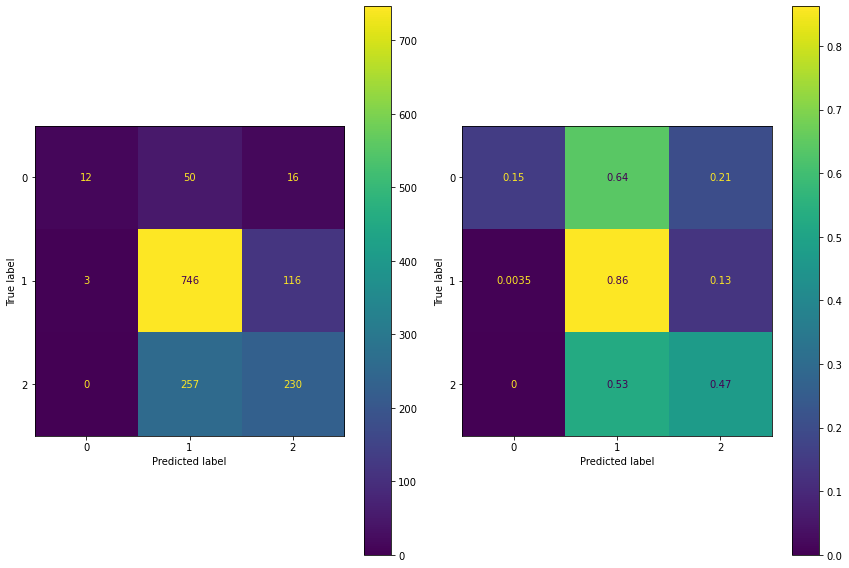

In [108]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

count = CountVectorizer(ngram_range=(1, 2))

final_X_train = pd.DataFrame(count.fit_transform(X_train_stems).todense(), index=X_train_stems.index,
                             columns=count.vocabulary_)
final_X_val = pd.DataFrame(count.transform(X_val_stems).todense(), index=X_val_stems.index,
                           columns=count.vocabulary_)

nb.fit(final_X_train, y_train)

fig, ax = plt.subplots(ncols=2, figsize=(12, 8))

ConfusionMatrixDisplay(confusion_matrix(y_val, nb.predict(final_X_val))).plot(ax=ax[0])
ConfusionMatrixDisplay(confusion_matrix(y_val, nb.predict(final_X_val), normalize='true')).plot(ax=ax[1])

fig.tight_layout();

The best model's performance corresponds loosely to class size. Let's try undersampling to get a better rate of prediction for the positive and negative classes.

In [109]:
y_train.value_counts()

1    3443
2    1919
0     356
Name: count, dtype: int64

In [110]:
# randomly undersample to make class weights equal

neutral_index = (y_train.loc[(y_train == 1)]).sample(356, random_state=seed).index
positive_index = (y_train.loc[(y_train == 2)]).sample(356, random_state=seed).index
undersampled_index = np.concatenate((neutral_index, positive_index, (y_train.loc[(y_train == 0)]).index))

y_train_undersampled = y_train.loc[undersampled_index].copy()

In [111]:
y_train_undersampled.value_counts()

1    356
2    356
0    356
Name: count, dtype: int64

In [112]:
X_train_undersampled = X_train_stems.loc[undersampled_index].copy()

final_X_train_undersampled = pd.DataFrame(count.fit_transform(X_train_undersampled).todense(),
                                          index=X_train_undersampled.index, columns=count.vocabulary_)
final_X_val_us = pd.DataFrame(count.transform(X_val).todense(), index=X_val.index, columns=count.vocabulary_)

In [113]:
nb.fit(final_X_train_undersampled, y_train_undersampled)

nb.score(final_X_val_us, y_val)

0.5671328671328671

Performance is worse. What about a different class weighting?

In [114]:
# randomly undersample to make adjust class weights

neutral_index = (y_train.loc[(y_train == 1)]).sample(356*3, random_state=seed).index
positive_index = (y_train.loc[(y_train == 2)]).sample(356*2, random_state=seed).index
undersampled_index = np.concatenate((neutral_index, positive_index, (y_train.loc[(y_train == 0)]).index))

y_train_undersampled = y_train.loc[undersampled_index].copy()
X_train_undersampled = X_train_stems.loc[undersampled_index].copy()

final_X_train_undersampled = pd.DataFrame(count.fit_transform(X_train_undersampled).todense(),
                                          index=X_train_undersampled.index, columns=count.vocabulary_)
final_X_val_us = pd.DataFrame(count.transform(X_val).todense(), index=X_val.index, columns=count.vocabulary_)

nb.fit(final_X_train_undersampled, y_train_undersampled)
nb.score(final_X_val_us, y_val)

0.6265734265734266

Another preprocessing technique we can try is that of term frequency- inverse document frequency vectorization (similar to count vectorization, but adjusted according to how often a word appears in a particular document *versus the corpus as a whole*.)

Here are the baseline results with tfidf vectorization:

In [115]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

final_X_train = pd.DataFrame(tfidf.fit_transform(X_train_stems).todense(), index=X_train_stems.index,
                             columns=tfidf.vocabulary_)
final_X_val = pd.DataFrame(tfidf.transform(X_val_stems).todense(), index=X_val_stems.index,
                           columns=tfidf.vocabulary_)

score_model(nb, final_X_train, y_train, final_X_val, y_val, 'stem', tfidf, nb)
score_model(rf, final_X_train, y_train, final_X_val, y_val, 'stem', tfidf, rf)

scaled_X_train = pd.DataFrame(ss.fit_transform(final_X_train), index=final_X_train.index,
                              columns=final_X_train.columns)
scaled_X_val = pd.DataFrame(ss.transform(final_X_val), index=final_X_val.index,
                            columns=final_X_val.columns)

score_model(svc, scaled_X_train, y_train, scaled_X_val, y_val, 'stem', tfidf, svc)

,tokenization,preprocessing,classifier,score
9,stem,"CountVectorizer(max_df=0.95, min_df=0.05)","(DecisionTreeClassifier(max_features='sqrt', r...",0.575524
10,stem,"CountVectorizer(ngram_range=(1, 2))","(DecisionTreeClassifier(max_features='sqrt', r...",0.657343
11,stem,TfidfVectorizer(),MultinomialNB(),0.648252
12,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.673427
13,stem,TfidfVectorizer(),SVC(kernel='poly'),0.616084


Let's tune the random forest.

In [116]:
rf = RandomForestClassifier(random_state=seed, class_weight='balanced')

score_model(rf, final_X_train, y_train, final_X_val, y_val, 'stem', tfidf, rf)

,tokenization,preprocessing,classifier,score
10,stem,"CountVectorizer(ngram_range=(1, 2))","(DecisionTreeClassifier(max_features='sqrt', r...",0.657343
11,stem,TfidfVectorizer(),MultinomialNB(),0.648252
12,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.673427
13,stem,TfidfVectorizer(),SVC(kernel='poly'),0.616084
14,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.665035


In [117]:
rf = RandomForestClassifier(random_state=seed, n_estimators=200)

score_model(rf, final_X_train, y_train, final_X_val, y_val, 'stem', tfidf, rf)

,tokenization,preprocessing,classifier,score
11,stem,TfidfVectorizer(),MultinomialNB(),0.648252
12,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.673427
13,stem,TfidfVectorizer(),SVC(kernel='poly'),0.616084
14,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.665035
15,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.671329


In [118]:
rf = RandomForestClassifier(random_state=seed, max_depth=2)

score_model(rf, final_X_train, y_train, final_X_val, y_val, 'stem', tfidf, rf)

,tokenization,preprocessing,classifier,score
12,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.673427
13,stem,TfidfVectorizer(),SVC(kernel='poly'),0.616084
14,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.665035
15,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.671329
16,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_depth=2, max_featu...",0.604895


In [119]:
rf = RandomForestClassifier(random_state=seed, max_depth=10)

score_model(rf, final_X_train, y_train, final_X_val, y_val, 'stem', tfidf, rf)

,tokenization,preprocessing,classifier,score
13,stem,TfidfVectorizer(),SVC(kernel='poly'),0.616084
14,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.665035
15,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.671329
16,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_depth=2, max_featu...",0.604895
17,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_depth=10, max_feat...",0.607692


In [120]:
rf = RandomForestClassifier(random_state=seed, max_depth=20)

score_model(rf, final_X_train, y_train, final_X_val, y_val, 'stem', tfidf, rf)

,tokenization,preprocessing,classifier,score
14,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.665035
15,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.671329
16,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_depth=2, max_featu...",0.604895
17,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_depth=10, max_feat...",0.607692
18,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_depth=20, max_feat...",0.626573


In [121]:
rf = RandomForestClassifier(random_state=seed, max_depth=100)

score_model(rf, final_X_train, y_train, final_X_val, y_val, 'stem', tfidf, rf)

,tokenization,preprocessing,classifier,score
15,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_features='sqrt', r...",0.671329
16,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_depth=2, max_featu...",0.604895
17,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_depth=10, max_feat...",0.607692
18,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_depth=20, max_feat...",0.626573
19,stem,TfidfVectorizer(),"(DecisionTreeClassifier(max_depth=100, max_fea...",0.679720


In [122]:
from sklearn.metrics import classification_report

rf.fit(final_X_train, y_train)

print(classification_report(y_val, rf.predict(final_X_val)))

              precision    recall  f1-score   support

           0       0.73      0.14      0.24        78
           1       0.68      0.91      0.78       865
           2       0.68      0.36      0.47       487

    accuracy                           0.68      1430
   macro avg       0.70      0.47      0.50      1430
weighted avg       0.68      0.68      0.64      1430



In [123]:
y_val.value_counts()

1    865
2    487
0     78
Name: count, dtype: int64

In [124]:
865*0.09

77.85

Our best classifier so far has a 91% recall of neutral tweets, a 14% recall of negative tweets and a 36% recall of positive tweets. Precision is much higher, with 73% precision for negative tweets, and 68% precision for both neutral and positive tweets.

This [paper](http://www.lrec-conf.org/proceedings/lrec2014/pdf/483_Paper.pdf) makes me feel a little better about the results, although the paper was written in 2014.

Another technique for preprocessing is to use word embeddings to vectorize the tweets, to avoid the sparsity seen with count vectorization and tfidf vectorization.

I will try using the pretrained GloVe embeddings which were trained on tweets.

We will use gensim to download the pretrained embeddings, but first, let's define a function to get the mean of the word vectors for all words in a tweet, given their GloVe embeddings.

Based on the average length (in words) of a tweet in this corpus, the function finds the zero-padded mean of the first 21 words in the tweet. 

In [125]:
# glove_embeddings must be stored in a variable called glove for this function to work

def get_mean_word_vector(tweet):
    '''Takes in a string (tweet) and returns the mean word vector of the tweet based on GloVe embeddings and a
    normalized tweet "length" of 21 words.'''
    # hold the GloVe embeddings for each word in the tweet
    glove_embeddings = []
    
    # iterate over each token in the tweet to add its embedding to the list
    for token in tweet.split():
        try:
            glove_embeddings.append(glove[token])
        except:
            # this token isn't in the GloVe vocab =(
            continue
    # take the padded mean of the first 21 words in the tweet
    if len(glove_embeddings) >= 21:
        padded_tweet = glove_embeddings[:21]
    elif len(glove_embeddings) >= 1:
        padded_tweet = glove_embeddings
    else:
        padded_tweet = np.array([np.zeros((50,)) for x in range(21)]) # need an array of arrays to output correct type
    return np.sum(padded_tweet, axis=0) / 21

Second, define a function which transforms a dataframe of tweet data into a dataframe in which each column represents a dimension of the mean word vector of a tweet (based on glove embeddings.)

In [126]:
def glove_embed(X_train, glove_dimensions):
    '''Get mean word vector for each tweet in df X_train based on GloVe embeddings.'''
    embedded_series = X_train.apply(get_mean_word_vector)
    
    text_features = {}
    
    for i in range(glove_dimensions):
        feature = f'feature_{i}'
        values = [embedding[i] for embedding in embedded_series.values]
        text_features[feature] = values
    
    return pd.DataFrame(text_features, index=X_train.index)

Now we can iterate over several versions of the GloVe embeddings obtained from twitter data (with different numbers of dimensions for the embeddings) and record the model score.

In [127]:
import gensim.downloader
glove_options = ['glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200']

from sklearn.preprocessing import MinMaxScaler

for which_glove in glove_options:
    glove = gensim.downloader.load(which_glove)
    n_dim = int(which_glove.split('-')[-1]) # number after last dash is the dimensions of the embeddings
    final_X_train = glove_embed(X_train_stems, n_dim)
    final_X_val = glove_embed(X_val_stems, n_dim)
    # using naive bayes as baseline; we need to scale between 0 and 1 to make all features positive (not an issue
    # with count or tfidf vectorization, just embeddings) so use min max scaler instead of standard scaler
    mms = MinMaxScaler()
    scaled_X_train = mms.fit_transform(final_X_train)
    scaled_X_val = mms.transform(final_X_val)
    score_model(nb, scaled_X_train, y_train, scaled_X_val, y_val, 'stem', which_glove, nb)

In [128]:
pd.DataFrame(model_eval)

,tokenization,preprocessing,classifier,score
0,stem,count_vectorize,random_forest,0.676923
1,stem,count_vectorize,naive_bayes,0.684615
2,stem,count_vectorize,support_vector,0.653147
3,lemmatize,count_vectorize,random_forest,0.679021
4,lemmatize,count_vectorize,naive_bayes,0.683916
5,lemmatize,count_vectorize,support_vector,0.647552
6,stem,"CountVectorizer(max_df=0.9, min_df=0.05)",MultinomialNB(),0.612587
7,stem,"CountVectorizer(max_df=0.95, min_df=0.05)",MultinomialNB(),0.612587
8,stem,"CountVectorizer(ngram_range=(1, 2))",MultinomialNB(),0.690909
9,stem,"CountVectorizer(max_df=0.95, min_df=0.05)","(DecisionTreeClassifier(max_features='sqrt', r...",0.575524


Let's give glove a chance with a different type of model - random forest.

In [129]:
rf = RandomForestClassifier(random_state=seed)

# last glove embedding was best (200-dimensional) so no need to re-preprocess data
score_model(rf, scaled_X_train, y_train, scaled_X_val, y_val, 'stem', which_glove, rf)

,tokenization,preprocessing,classifier,score
20,stem,glove-twitter-25,MultinomialNB(),0.604895
21,stem,glove-twitter-50,MultinomialNB(),0.604895
22,stem,glove-twitter-100,MultinomialNB(),0.604895
23,stem,glove-twitter-200,MultinomialNB(),0.605594
24,stem,glove-twitter-200,"(DecisionTreeClassifier(max_features='sqrt', r...",0.653846


This may seem like an odd approach, but I wonder if PCA could help our machine learning algorithm to learn from the data.

In [130]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(scaled_X_train)

# how many components must be kept to explain roughly 95% of the variance in the data?
np.argmax(np.isclose(np.array([0.95]*200), np.cumsum(pca.explained_variance_ratio_), 0.005))

133

In [131]:
pca = PCA(n_components=133)

reduced_X_train = pca.fit_transform(scaled_X_train)
reduced_X_val = pca.transform(scaled_X_val)

score_model(rf, reduced_X_train, y_train, reduced_X_val, y_val, 'stem', [which_glove, pca], rf)

,tokenization,preprocessing,classifier,score
21,stem,glove-twitter-50,MultinomialNB(),0.604895
22,stem,glove-twitter-100,MultinomialNB(),0.604895
23,stem,glove-twitter-200,MultinomialNB(),0.605594
24,stem,glove-twitter-200,"(DecisionTreeClassifier(max_features='sqrt', r...",0.653846
25,stem,"[glove-twitter-200, PCA(n_components=133)]","(DecisionTreeClassifier(max_features='sqrt', r...",0.640559


Reducing the dimensionality of the glove embeddings artificially didn't have a positive effect on the model's performance.

One last technique we will try (prior to stacking) is generating our own word embeddings based on the tweets in our corpus, then creating a mean word vector for each tweet.

First, we define a helper function to get the mean word vector for each tweet (again, assuming a tweet length of 21 words.) Notice that the word2vec model we train has to be passed into the function as well as the tweet.

In [132]:
# this function takes in a word2vec model, w2v
def get_custom_mean_word_vector(tweet, w2v):
    '''Takes in a string (tweet) and returns the mean word vector of the tweet based on custom word2vec embeddings
    and a normalized tweet "length" of 21 words.'''
    embeddings = []
    for token in tweet.split():
        try:
            embeddings.append(w2v.wv[token])
        except:
            continue
            
    # check number of embeddings in tweet and pad or trim as needed
    if len(embeddings) >= 21:
        padded_tweet = embeddings[:21]
    elif len(embeddings) >= 1:
        padded_tweet = embeddings
    else:
        padded_tweet = np.array([np.zeros((w2v.vector_size,)) for x in range(21)])
        
    return np.sum(padded_tweet, axis=0) / 21

Next, we develop a function to feed the embeddings of a Word2Vec model to our helper function above to determine the mean word vector for each tweet in our training data, then produce and return a matrix in which each column corresponds to a dimension of the mean word embedding for that tweet.

In [133]:
# Word2Vec model needs to be FIT (instantiated) before calling this function; pass as 2nd arg
def custom_embed(X_train, w2v):
    '''Takes in training data and an instantiated gensim Word2Vec model; returns the matrix form of the training
    data based on a mean word vector of length 21 words and the embeddings from Word2Vec model.'''
    
    # apply helper function to X_train to get mean word vector for each tweet
    embedded_series = X_train.apply(get_custom_mean_word_vector, args=(w2v,))
    
    # convert embeddings to matrix form (each col corresponds to a dimension of the mean word embedding)
    text_features = {}
    
    for i in range(w2v.vector_size):
        feature = f'feature_{i}'
        values = [embedding[i] for embedding in embedded_series.values]
        text_features[feature] = values
    
    return pd.DataFrame(text_features, index=X_train.index)

Now, we can train a "baseline" embedding space and pass those embeddings to a classifier (in this case, Naive Bayes.)

In [134]:
from gensim.models import Word2Vec

# try default settings for training first
w2v = Word2Vec(X_train_stems.map(lambda x: x.split()))

scaled_X_train = mms.fit_transform(custom_embed(X_train_stems, w2v))
scaled_X_val = mms.transform(custom_embed(X_val_stems, w2v))

score_model(nb, scaled_X_train, y_train, scaled_X_val, y_val, 'stem', w2v, nb)

,tokenization,preprocessing,classifier,score
22,stem,glove-twitter-100,MultinomialNB(),0.604895
23,stem,glove-twitter-200,MultinomialNB(),0.605594
24,stem,glove-twitter-200,"(DecisionTreeClassifier(max_features='sqrt', r...",0.653846
25,stem,"[glove-twitter-200, PCA(n_components=133)]","(DecisionTreeClassifier(max_features='sqrt', r...",0.640559
26,stem,"Word2Vec<vocab=1641, vector_size=100, alpha=0....",MultinomialNB(),0.604895


In [135]:
# try varying the settings for training the neural net which produces word embeddings
# adjust learning rate
w2v = Word2Vec(X_train_stems.map(lambda x: x.split()), alpha=0.01)

scaled_X_train = mms.fit_transform(custom_embed(X_train_stems, w2v))
scaled_X_val = mms.transform(custom_embed(X_val_stems, w2v))

score_model(nb, scaled_X_train, y_train, scaled_X_val, y_val, 'stem', w2v, nb)

,tokenization,preprocessing,classifier,score
23,stem,glove-twitter-200,MultinomialNB(),0.605594
24,stem,glove-twitter-200,"(DecisionTreeClassifier(max_features='sqrt', r...",0.653846
25,stem,"[glove-twitter-200, PCA(n_components=133)]","(DecisionTreeClassifier(max_features='sqrt', r...",0.640559
26,stem,"Word2Vec<vocab=1641, vector_size=100, alpha=0....",MultinomialNB(),0.604895
27,stem,"Word2Vec<vocab=1641, vector_size=100, alpha=0.01>",MultinomialNB(),0.595804


In [136]:
# try varying the settings for training the neural net which produces word embeddings
# our documents are short, so try adjusting batch size & window
w2v = Word2Vec(X_train_stems.map(lambda x: x.split()), window=3, batch_words=300)

scaled_X_train = mms.fit_transform(custom_embed(X_train_stems, w2v))
scaled_X_val = mms.transform(custom_embed(X_val_stems, w2v))

score_model(nb, scaled_X_train, y_train, scaled_X_val, y_val, 'stem', w2v, nb)

,tokenization,preprocessing,classifier,score
24,stem,glove-twitter-200,"(DecisionTreeClassifier(max_features='sqrt', r...",0.653846
25,stem,"[glove-twitter-200, PCA(n_components=133)]","(DecisionTreeClassifier(max_features='sqrt', r...",0.640559
26,stem,"Word2Vec<vocab=1641, vector_size=100, alpha=0....",MultinomialNB(),0.604895
27,stem,"Word2Vec<vocab=1641, vector_size=100, alpha=0.01>",MultinomialNB(),0.595804
28,stem,"Word2Vec<vocab=1641, vector_size=100, alpha=0....",MultinomialNB(),0.604196


In [137]:
# try varying the settings for training the neural net which produces word embeddings
# adjust dimensionality of embeddings
w2v = Word2Vec(X_train_stems.map(lambda x: x.split()), vector_size=200)

scaled_X_train = mms.fit_transform(custom_embed(X_train_stems, w2v))
scaled_X_val = mms.transform(custom_embed(X_val_stems, w2v))

score_model(nb, scaled_X_train, y_train, scaled_X_val, y_val, 'stem', w2v, nb)

,tokenization,preprocessing,classifier,score
25,stem,"[glove-twitter-200, PCA(n_components=133)]","(DecisionTreeClassifier(max_features='sqrt', r...",0.640559
26,stem,"Word2Vec<vocab=1641, vector_size=100, alpha=0....",MultinomialNB(),0.604895
27,stem,"Word2Vec<vocab=1641, vector_size=100, alpha=0.01>",MultinomialNB(),0.595804
28,stem,"Word2Vec<vocab=1641, vector_size=100, alpha=0....",MultinomialNB(),0.604196
29,stem,"Word2Vec<vocab=1641, vector_size=200, alpha=0....",MultinomialNB(),0.581818


In [138]:
# try varying the settings for training the neural net which produces word embeddings
# adjust dimensionality of embeddings
w2v = Word2Vec(X_train_stems.map(lambda x: x.split()), vector_size=50)

scaled_X_train = mms.fit_transform(custom_embed(X_train_stems, w2v))
scaled_X_val = mms.transform(custom_embed(X_val_stems, w2v))

score_model(nb, scaled_X_train, y_train, scaled_X_val, y_val, 'stem', w2v, nb)

,tokenization,preprocessing,classifier,score
26,stem,"Word2Vec<vocab=1641, vector_size=100, alpha=0....",MultinomialNB(),0.604895
27,stem,"Word2Vec<vocab=1641, vector_size=100, alpha=0.01>",MultinomialNB(),0.595804
28,stem,"Word2Vec<vocab=1641, vector_size=100, alpha=0....",MultinomialNB(),0.604196
29,stem,"Word2Vec<vocab=1641, vector_size=200, alpha=0....",MultinomialNB(),0.581818
30,stem,"Word2Vec<vocab=1641, vector_size=50, alpha=0.025>",MultinomialNB(),0.604895
